In [1]:
import os
import re
#import ROOT
import hist
from hist import Hist
from hist.axis import IntCategory, Regular, StrCategory
import pickle
import mplhep as hep
from glob import glob
import numpy as np
import awkward as ak
from tabulate import tabulate
from IPython import embed
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
hep.style.use('CMS')
print('iminuit version:', iminuit.__version__)
import itertools
from collections import defaultdict
import glob

iminuit version: 2.30.1


In [2]:
## Load the data_storage from the previous run

if os.path.exists('data_storage_DesyTau.pkl'):
    with open('data_storage_DesyTau.pkl', 'rb') as file:
        data_storage_dict = pickle.load(file)
    # Convert to defaultdict (optional, if you need default values)
    data_storage = defaultdict(lambda: {'values': [], 'err': [], 'colour': None, 'location': None})
    # Load the data and update it
    data_storage.update(data_storage_dict)
else:
    data_storage = defaultdict(lambda: {'values': [], 'err': [], 'colour': None, 'location': None})
#data_storage

In [3]:
# Define model and fit
def model(x, a, b, c):
    return a*np.cos(x+c) + b

def fit(x, y, err=0.05, model=model):
    lsq = LeastSquares(x, y, err, model)
    m = Minuit(lsq, a=0.1, b=0.1, c=1.0)
    m.fixed = False
    m.migrad()
    m.hesse()
    return m, err, m.values["a"], m.errors["a"], m.values["b"], m.errors["b"], m.values["c"]

def comp_asymmetry(arr1, arr2):
    return (1/arr1.size)*np.sum(np.abs((arr1-arr2)/(arr1+arr2)))

def comp_asymmetry_error(arr1, arr2, err1, err2):
    denom = arr1 + arr2
    term1 = err1 * np.abs((2 * arr2) / (denom**2))
    term2 = err2 * np.abs((2 * arr1) / (denom**2))
    sigma_A = np.sqrt(np.sum(term1**2 + term2**2)) / arr1.size
    return sigma_A

In [4]:
## Define the categories and tags

tags = ["pv", "dp"]

shiftdict = {
    "cp_even": {"shift": 150, "colour": "#d62839", "location": "upper right", "linestyle": "solid"},
    "cp_odd": {"shift": 151, "colour": "#28348e", "location": "lower left", "linestyle": (0, (2, 2))},
    "cp_maxmix": {"shift": 0, "colour": "#2b663c", "location": "lower right", "linestyle":(0, (2, 1, 0.5, 1, 0.5, 1, 0.5, 1))},
}
simpledict = {
    'cat_mutau_sr' : {'simple' : 'mutau_inclusive', 'math' : r'$\mu \tau$ inclusive'},
    'cat_mutau_sr__tau2a1_3pr' : {'simple' : 'mua13pr', 'math' : r'$\mu a^{3pr}$'},
    'cat_mutau_sr__prompt__hig__cat2__tau2a1_3pr' : {'simple' : 'mua13pr_bdt', 'math' : r'$\mu a^{3pr}$ BDT signal'},
    'cat_mutau_sr__jet_fakes__fake' : {'simple' : 'cat_mutau_sr__jet_fakes__fake', 'math' : r'cat_mutau_sr__jet_fakes__fake'},
}

dir_names = [ #"03_DesyTau_diff_pv_methods/ggF",
              #"03_DesyTau_diff_pv_methods/VBF",
              #"04_DesyTau_phi_reorder_main_struc/ggF",
              #"04_DesyTau_phi_reorder_main_struc/VBF",
              #"05_DesyTau_fix_MTT/ggF",
              #"05_DesyTau_fix_MTT/VBF",
              "03_test_small/ggF",
              "03_test_small/VBF",
            ]

chosen_categories = list(simpledict.keys())
chosen_categories
chosen_categories = ['cat_mutau_sr__tau2a1_3pr','cat_mutau_sr__jet_fakes__fake']

In [11]:
for chosen_category in chosen_categories:

    cat_math = simpledict[chosen_category]['math']
    cat_simple = simpledict[chosen_category]['simple']

    for dir_name in dir_names:
    
        if "VBF" in dir_name:
            base = 12000
        else:
            base = 11000 #=ggF
    
        # CP mapping depending on process name
        if "VBF" in dir_name:
            process_map = {
                "h_vbf_htt_sm" : "cp_even",
                "h_vbf_htt_mm" : "cp_maxmix",
                "h_vbf_htt_cpo": "cp_odd",
            }
            is_vbf = "VBF"
        elif "ggF" in dir_name:
            process_map = {
                "h_ggf_htt_sm_prod_sm" : "cp_even",
                "h_ggf_htt_mm_prod_sm" : "cp_maxmix",
                "h_ggf_htt_cpo_prod_sm": "cp_odd",
            }
            is_vbf = "ggF"
        else:
            process_map = {}  # for control or other categories
            is_vbf = "control"
    
        
        ## Combine the Pickle files if needed
        subdirs = [
            "cpo",
            "mm",
            "sm"
        ]
        
        base_dir = os.path.join("INPUT", dir_name)
        place_combined_pickels = os.path.join(base_dir, "combined_pickles")
        output_dir = os.path.join("OUTPUT", dir_name)
        os.makedirs(place_combined_pickels, exist_ok=True)
        os.makedirs(output_dir, exist_ok=True)
        
        
        #file_names = set(os.path.basename(f) for f in glob.glob(os.path.join(base_dir, subdirs[0], "*.pickle"))) # 4(configs)x2(methods) files
        for subdir in subdirs:
            folder = os.path.join(base_dir, subdir)
    
            for suffix in ["pv", "dp"]: #tags
                # tous les fichiers *_pv.pickle (ou *_dp.pickle) du sous-dossier
                all_files = glob.glob(os.path.join(folder, f"*_{suffix}*.pickle"))
    
                # Grouper par nom commun sans le préfixe (preee, postee, prebpix, postbpix)
                groups = {}
                for path in all_files:
                    name = os.path.basename(path)
                    # Ignore déjà les fichiers all_configs_...
                    if name.startswith("all_configs_"):
                        continue
                    # retirer le préfixe avant le 1er "_"
                    common_name = name.split("_", 1)[1]  
                    groups.setdefault(common_name, []).append(path)
    
                # Fusionner chaque groupe
                    for common_name, file_list in groups.items():
                        combined = None
                        for fpath in file_list:
                            with open(fpath, "rb") as f:
                                hist = pickle.load(f)
                                if combined is None:
                                    combined = hist.copy()
                                else:
                                    combined += hist  # somme bin-à-bin
    
                        # Sauver le pickle combiné
                        output_path = os.path.join(folder, f"all_configs_{common_name}")
                        with open(output_path, "wb") as f:
                            pickle.dump(combined, f)
                        #print(f"✅ {subdir}: Sauvé {output_path}")
                        
        # === NEU: Kombiniere alle CP-Histogramme (cpo, sm, mm) ===
        file_names = set(os.path.basename(f) for f in glob.glob(os.path.join(base_dir, subdirs[0], "all_configs_*.pickle")))
    
        for file_name in file_names:
            histograms_per_cp = {}
    
            # Load histograms from each subdir
            for subdir in subdirs:
                file_path = os.path.join(base_dir, subdir, file_name)
                print("Loading file:", file_path)
                
                if not os.path.exists(file_path):
                    print(f"⚠️ Datei fehlt: {file_path}, skip")
                    continue
                
                with open(file_path, 'rb') as f:
                    hist = pickle.load(f)
                    print("Type of hist object:", type(hist))
                    # Check which cats exist
                    #begin = "cat_mutau_sr__"
                    #for cat in hist.axes['category']:
                    #    if cat.startswith(begin):
                    #        print(cat)
                    # Kategorie auswählen, falls nötig
                hist = hist[{"category": chosen_category}]
    
                # Extract histograms per process name
                histograms_per_cp[subdir] = hist
    
    
            combined_output_path = os.path.join(place_combined_pickels, f"cp_all_{file_name}")
            if os.path.exists(combined_output_path):
                print(f"✅ Bereits vorhanden: {combined_output_path}, skip")
                continue
            
            # Combine histograms
            cp_keys = list(histograms_per_cp.keys())
            combined_hist = histograms_per_cp[cp_keys[0]].copy()
            for cp_key in cp_keys[1:]:
                combined_hist += histograms_per_cp[cp_key]
    
            with open(combined_output_path, 'wb') as f:
                pickle.dump(combined_hist, f)
            print(f"✅ Gespeichert: {combined_output_path}")
    
    
        
        
        ## Loop over the tags and categories, do the fitting and save the results
        for tag in tags:  # Loop over tags
            print(f"Processing tag: {tag}")
            file_list = glob.glob(f"{base_dir}/combined_pickles/cp_all_all_configs_hist__*.pickle", recursive=True)
    
            
            for file in file_list:
                print(f"Checking file: {file}, looking for tag: {tag}")
                if tag in file:
                    print(f"Take file: {file}")
                if tag not in file:
                    print(f"Skipping: {file}")
                    continue
                
                if "dp" in tag and "reco" in file:
                    is_gen = "Reco"
                elif "dp" in tag and "gen" in file:
                    is_gen = "Gen"
                elif "pv" in tag and "reco" in file:
                    is_gen = "Reco"
                elif "pv" in tag and "mtt" in file:
                    is_gen = "MTT"
                elif "pv" in tag and "gef" in file:
                    is_gen = "GEF"
                elif "pv" in tag and "gen" in file:
                    is_gen = "Gen"
                else:
                    is_gen = tag
                    print("!file outside is_gen categories!")
        
                
                tag_kind = f"{tag} {is_gen}"
                print(f">>>---- Processing file : {file} --->>>")
                print(f">>>---- Tag & is_gen : {tag_kind}")
                fileptr = open(file, 'rb')
                data = pickle.load(fileptr)
                nbin = data.shape[2]
                print("nbin", nbin)
                fileptr.close()
        
                if not hasattr(data, 'axes'):
                    print(f"Warning: 'axes' not found in {file}. Skipping...")
                    continue
                
                axes = data.axes
                process_axis = axes['process']
        
                cparray = {}
                for proc_name, cp_key in process_map.items():
                    if proc_name not in process_axis:
                        print(f"⚠️ {proc_name} not found in process_axis")
                        continue
                    #idx = process_axis.index(proc_name)
                    #values = data[idx, :, :].values()
                    values = data[{"process": proc_name}].values()
                    #errors = data[idx, :, :].variances() ** 0.5
                    errors = data[{"process": proc_name}].variances() ** 0.5
                    print("cp_key : ", cp_key)
                    cparray[cp_key] = {
                        "values": values,
                        "errors": errors,
                        "colour": shiftdict[cp_key]["colour"],
                        "location": shiftdict[cp_key]["location"],
                        "linestyle": shiftdict[cp_key]["linestyle"],
                    }

                print("cparray[cp_key]", cparray[cp_key])
        
                x = np.linspace(0., 2*np.pi, nbin)
    
                    
                plt.figure(figsize=(8.9, 6.6))
                hep.cms.text("Private Work", loc=1)
                line_width = 2
                legend_line_width = line_width
        
                ## Initialise category in data_storage if not already there
                if cat_simple not in data_storage:
                    data_storage[cat_simple] = {
                        f"{dir_name}": {},  # Initialise the tags key to store per-category tags
                    }
                if dir_name not in data_storage[cat_simple]:
                    data_storage[cat_simple][dir_name] = {}
                if tag_kind not in data_storage[cat_simple][dir_name]:
                    data_storage[cat_simple][dir_name][tag_kind] = {}
        
                for hyp, shift_props in shiftdict.items():  # Loop over hypotheses
                    if hyp not in cparray: #such that plot works also with less than all cp hypotheses
                        print(f"⚠️ {hyp} not found in cparray, skipping")
                        continue
                    shift, colour, location, linestyle = shift_props["shift"], shift_props["colour"], shift_props["location"], shift_props["linestyle"]
                    #print("hyp : ", hyp, "shift_props :", shift_props) #hyp = shift
        
                    hypothesis_zip = cparray[hyp]  # gives per hypothesis: {'values': array, 'errors': array, '...': 'black', 'location': '...'}
                    hypothesis_fit_vals, hypothesis_fit_errs = np.ravel(hypothesis_zip["values"]), np.ravel(hypothesis_zip["errors"])
        
                    # Fit the Hypothesis
                    m, err, a, sigma_a, b, sigma_b, c = fit(x, hypothesis_fit_vals, hypothesis_fit_errs)
        
        
                    if tag_kind not in data_storage[cat_simple][dir_name]:  
                        data_storage[cat_simple][dir_name][tag_kind] = {}  # Initialise tag_kind in [tag_kind] if not already there
        
                    data_storage[cat_simple][dir_name][tag_kind][hyp] = {  # Directly use hypothesis name
                        "values": np.array(hypothesis_fit_vals), # hypothesis_fit_vals.tolist(),
                        "err": err,
                        "colour": colour,
                        "location": location,
                        #"m": m,
                    }
        
        
                    # Plot the results
                    plt.errorbar(x, hypothesis_fit_vals, hypothesis_fit_errs, fmt="o", color=colour)
                    fit_curve = model(x, *m.values)
                    plt.plot(x, fit_curve, color=colour, linestyle=linestyle, linewidth=line_width)
                    fit_info = [
                        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} ≈ {m.fmin.reduced_chi2:.1f}",
                    ]
                    legend_handle = Line2D([0], [0], color=colour, linestyle=linestyle, linewidth=legend_line_width, label=f"CP {hyp[3:]}")
                    legend = plt.legend(handles=[legend_handle], title="\n".join(fit_info), frameon=False, loc=location, fontsize=20, title_fontsize=15)
                    plt.gca().add_artist(legend)
        
                    fit_y_min = np.min(fit_curve)
                    fit_y_max = np.max(fit_curve)
                    y_min = fit_y_min - 0.3 * fit_y_min
                    y_max = fit_y_max + 0.2 * fit_y_max
                    plt.ylim(y_min, y_max)
    
                # Alle vorhandenen Hypothesen in cparray
                existing_hyps = list(cparray.keys())
        
                #for category1, category2 in itertools.combinations(shiftdict.keys(), 2):  # Loop over pairs of hypotheses (asymmetry calculations)
                for category1, category2 in itertools.combinations(existing_hyps, 2):  # Loop over pairs of existing hypotheses (asymmetry calculations)
                    hypothesis1 = np.ravel(cparray[category1]["values"])
                    hypothesis2 = np.ravel(cparray[category2]["values"])
                    error1 = np.ravel(cparray[category1]["errors"])
                    error2 = np.ravel(cparray[category2]["errors"])
        
                    asymmetry = comp_asymmetry(hypothesis1, hypothesis2)
                    asymmetry_error = comp_asymmetry_error(hypothesis1, hypothesis2, error1, error2)
        
                    combo_name = f"{category1}_vs_{category2}"
                    print("combo_name : ", combo_name)
        
                    if combo_name not in data_storage[cat_simple][dir_name][tag_kind]:
                        data_storage[cat_simple][dir_name][tag_kind][combo_name] = {}  # Initialize combo_name under tag_kind if not already there
        
                    # Store the asymmetry result for this category and tag_kind
                    data_storage[cat_simple][dir_name][tag_kind][combo_name]["asymmetry_val"] = asymmetry
                    data_storage[cat_simple][dir_name][tag_kind][combo_name]["asymmetry_error"] = asymmetry_error
        
        
                # Save the final plot
                asymmetry_val_even_odd = data_storage[cat_simple][dir_name][tag_kind]["cp_even_vs_cp_odd"]["asymmetry_val"]
                asymmetry_error_even_odd = data_storage[cat_simple][dir_name][tag_kind]["cp_even_vs_cp_odd"]["asymmetry_error"]
                asymmetry_val_even_odd_rounded = round(asymmetry_val_even_odd, 3)
                asymmetry_error_even_odd_rounded = round(asymmetry_error_even_odd, 3)
        
                x_label = r"$\Phi_{CP}$" + f" ({tag_kind})"
                #if is_gen == "Gen":
                #    x_label += " (Gen)"
    
                info_text = f"category: {cat_math}"
    
    
                if info_text:
                    plt.annotate(info_text, xy=(0.01, 1.012), xycoords="axes fraction", fontsize=14,
                             bbox=dict(boxstyle="round,pad=0.3", facecolor='none', edgecolor='none'))
        
                plt.xlabel(x_label)
                plt.ylabel("a.u")
                plt.title(f"($A_{{even,odd}}$ = {asymmetry_val_even_odd_rounded}$\\,\\pm\\,${asymmetry_error_even_odd_rounded})", fontsize=25, loc='right')
                plt.tight_layout()
                plt.savefig(f"{output_dir}/{chosen_category}_{tag_kind}_{is_vbf}.pdf", dpi=300)
                #plt.show()
                plt.close()
                    

Loading file: INPUT/03_test_small/ggF/cpo/all_configs_hist__var_phi_cp_mu_a1_3pr_pv_mtt.pickle
Type of hist object: <class 'hist.hist.Hist'>
Loading file: INPUT/03_test_small/ggF/mm/all_configs_hist__var_phi_cp_mu_a1_3pr_pv_mtt.pickle
Type of hist object: <class 'hist.hist.Hist'>
Loading file: INPUT/03_test_small/ggF/sm/all_configs_hist__var_phi_cp_mu_a1_3pr_pv_mtt.pickle
Type of hist object: <class 'hist.hist.Hist'>
✅ Bereits vorhanden: INPUT/03_test_small/ggF/combined_pickles/cp_all_all_configs_hist__var_phi_cp_mu_a1_3pr_pv_mtt.pickle, skip
Loading file: INPUT/03_test_small/ggF/cpo/all_configs_hist__var_phi_cp_mu_a1_3pr_dp_reco.pickle
Type of hist object: <class 'hist.hist.Hist'>
Loading file: INPUT/03_test_small/ggF/mm/all_configs_hist__var_phi_cp_mu_a1_3pr_dp_reco.pickle
Type of hist object: <class 'hist.hist.Hist'>
Loading file: INPUT/03_test_small/ggF/sm/all_configs_hist__var_phi_cp_mu_a1_3pr_dp_reco.pickle
Type of hist object: <class 'hist.hist.Hist'>
✅ Bereits vorhanden: INPUT/

In [11]:
def print_nested_keys(d, prefix=''):
    if isinstance(d, dict):
        for key, value in d.items():
            new_prefix = f'{prefix} -> {key}' if prefix else key
            print(new_prefix)
            print_nested_keys(value, new_prefix)

print_nested_keys(data_storage)

mua13pr
mua13pr -> 05_DesyTau_fix_MTT/ggF
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_even
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_even -> values
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_even -> err
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_even -> colour
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_even -> location
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_odd
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_odd -> values
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_odd -> err
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_odd -> colour
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_odd -> location
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_maxmix
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_maxmix -> values
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_maxmix -> err
mua13pr -> 05_DesyTau_fix_MTT/ggF -> pv Reco -> cp_maxmix -> colour
mua13pr -> 05_DesyTau

# Compare the asymmetries + errors

In [8]:
colour_palette = ['#d62839', '#28348e', '#2b663c']

def compare_asymmetries_pv(data_storage, selected_cats=None, selected_datasets=None, selected_tags=None, selected_keys=None):
    if selected_cats is None:
        selected_cats = list(data_storage.keys())
    if selected_datasets is None:
        selected_datasets = [ds for cat in selected_cats for ds in data_storage[cat_simple].keys()]
    if selected_keys is None:
        selected_keys = [key for cat in selected_cats for ds in selected_datasets for tag in selected_tags for key in data_storage[cat_simple][ds].get(tag, {}).keys()]

    print('selected_cats', selected_cats)
    print('selected_datasets:', selected_datasets)
    print('selected_tags', selected_tags)
    print('selected_keys', selected_keys)

    cat_math = simpledict[chosen_category]['math']
    cat_simple = simpledict[chosen_category]['simple']

    first_path = selected_datasets[0]
    output_path = first_path.split('/')[0]
    output_dir = os.path.join('OUTPUT', output_path)
    os.makedirs(output_dir, exist_ok=True)                            # Output-Ordner erstellen, falls nicht existent

    used_tags = {}

    for tag in selected_tags:
        words = tag.split()
    
        # extract method
        first = words[0].lower()
        if first == 'dp':
            method = 'dp'
        elif first == 'pv':
            method = 'pv'
        else:
            method = ''

        # extract reconstruction
        second = ' '.join(words[1:]).lower()
        if 'gen' in second:
            reco_label = r'gen $p_T^{\tau}$'
        elif 'reco' in second:
            reco_label = r'visible $p_T^{\tau}$'
        elif 'mtt' in second:
            reco_label = r'fastMTT $p_T^{\tau}$'
        elif 'gef' in second:
            reco_label = r'GEF $p_T^{\tau}$'
        else:
            reco_label = tag  # fallback

        # assemble final label
        if method:
            used_tags[tag] = fr'{method} {reco_label}'
        else:
            used_tags[tag] = reco_label


    info_text = []
    math_label = None

    reverse_simple = {v["simple"]: k for k, v in simpledict.items()}
    
    if len(selected_cats) == 1:
        cat_simple = selected_cats[0]                   # e.g. 'mua13pr'
        original_key = reverse_simple.get(cat_simple)   # e.g. 'cat_mutau_sr__tau2a1_3pr'
        # fallback = if the key is not found, use the simple string itself
        math_label = simpledict.get(original_key, {}).get("math", cat_simple)

        print("math_label =", math_label)

        info_text.append(f"Category : {math_label}")
    if len(selected_datasets) == 1:
        info_text.append(f'Version : {selected_datasets[0]}')
    if len(selected_tags) == 1:
        info_text.append(f'Method : {selected_tags[0]}')
    if len(selected_keys) == 1:
        info_text.append(f'Asymmetry of : {selected_keys[0]}')

    # Replace _ with spaces
    info_text = '\n'.join(line.replace('_', ' ').replace('cp', 'CP') for line in info_text) if info_text else None

    asymmetry_values = []
    asymmetry_errors = []
    labels = []
    colours = []
    dir_names = []  # <--- New list to store dir_name

    colour_map = {dir_name: colour_palette[i % len(colour_palette)] for i, dir_name in enumerate(selected_datasets)}
    legend_handles = {}

    for cat in selected_cats:
        if cat not in data_storage:
            continue

        for dir_name in selected_datasets:
            print('dir_name : ', dir_name)
            if dir_name not in data_storage[cat]:
                continue
            colour = colour_map[dir_name]
            if dir_name not in legend_handles:
                legend_handles[dir_name] = plt.Line2D([0], [0], marker='o', color=colour, linestyle='None', label=dir_name)

            available_tags = [tag for tag in selected_tags if tag in data_storage[cat][dir_name]]

            for tag in available_tags:
                for key in selected_keys:
                    if key in data_storage[cat][dir_name][tag]:
                        data_entry = data_storage[cat][dir_name][tag][key]

                        if '_vs_' in key and 'asymmetry_val' in data_entry and 'asymmetry_error' in data_entry:
                            asymmetry_values.append(data_entry['asymmetry_val'])
                            asymmetry_errors.append(data_entry['asymmetry_error'])
                            dir_names.append(dir_name)  # <--- store dir_name as well

                            label_parts = []
                            if len(selected_cats) > 1:
                                label_parts.append(cat)
                            if len(selected_tags) > 1:
                                label_parts.append(tag)
                            if len(selected_keys) > 1:
                                label_parts.append(key)

                            labels.append(' - '.join(label_parts))
                            colours.append(colour)


    asymmetry_values = np.array(asymmetry_values)
    asymmetry_errors = np.array(asymmetry_errors)

    plt.figure(figsize=(7.7, 5.5))
    hep.cms.text('Private work', loc=0)

    unique_labels = list(dict.fromkeys(labels))
    label_to_xpos = {label: i for i, label in enumerate(unique_labels)}
    # Make sure that all lists are of the same length
    assert len(labels) == len(asymmetry_values) == len(asymmetry_errors) == len(dir_names)

    max_values = {}
    max_errors = {}
    max_values_vbf = {}
    max_errors_vbf = {}

    # Use dir_names to correctly assign ggF and VBF
    for label, value, error, dir_name in zip(labels, asymmetry_values, asymmetry_errors, dir_names):
        print('dir_name : ', dir_name)
        if 'VBF' in dir_name:  # if VBF-Dataset
            print(f'VBF erkannt: {dir_name}, label: {label}, value: {value}')
            if label not in max_values_vbf or value > max_values_vbf[label]:
                max_values_vbf[label] = value
                max_errors_vbf[label] = error
        else:  # if ggF-Dataset
            print(f'ggF erkannt: {dir_name}, label: {label}, value: {value}')

            if label not in max_values or value > max_values[label]:
                max_values[label] = value
                max_errors[label] = error
    filtered_labels = list(set(max_values.keys()) | set(max_values_vbf.keys()))
    print('filtered_labels: ',filtered_labels)
    filtered_values = [max_values.get(label, 0) for label in filtered_labels]
    filtered_errors = [max_errors.get(label, 0) for label in filtered_labels]

    filtered_values_vbf = [max_values_vbf.get(label, 0) for label in filtered_labels]
    filtered_errors_vbf = [max_errors_vbf.get(label, 0) for label in filtered_labels]

    filtered_x_positions = [label_to_xpos[label] for label in filtered_labels]
    
    width = 0.19
    gap = 0.02
    
    # Plot bars for ggF
    plt.bar(filtered_x_positions, filtered_values, yerr=filtered_errors, width=width, label='ggF', color=colour_palette[0], capsize=5)
    # Plot bars for VBF slightly shifted to the right
    plt.bar([x + width + gap for x in filtered_x_positions], filtered_values_vbf, yerr=filtered_errors_vbf, width=width, label='VBF', color=colour_palette[1], capsize=5)

    # Labels, legend, and formatting
    plt.legend()
    
    for label, max_val in max_values.items():
        max_err = max_errors[label]
        x_pos = label_to_xpos[label]

    if asymmetry_values.size > 0:
        A_y_min = np.min(asymmetry_values)
        A_y_max = np.max(asymmetry_values)
        y_max = A_y_max + 0.4 * A_y_max
        plt.ylim(0, y_max)

    mapped_labels = [used_tags.get(label, label) for label in filtered_labels]
    #plt.xticks(ticks=filtered_x_positions, labels=mapped_labels, rotation=45)
    plt.xticks(ticks=[x + (width / 2) + (gap / 2) for x in filtered_x_positions], labels=mapped_labels, rotation=45)


    

    plt.ylabel('Asymmetry')
    #plt.title('Comparison of Asymmetries', pad=45)

    if info_text:
        plt.annotate(info_text, xy=(0.05, 0.83), xycoords='axes fraction', fontsize=14,
                     bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    
    plt.grid()
    plt.savefig(f'{output_dir}/Asymmetry_DesyTau_diff_cat_{cat_simple}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

selected_cats ['mua13pr']
selected_datasets: ['03_test_small/ggF', '03_test_small/VBF']
selected_tags ['dp Reco', 'pv MTT']
selected_keys ['cp_even_vs_cp_odd']
math_label = $\mu a^{3pr}$
dir_name :  03_test_small/ggF
dir_name :  03_test_small/VBF
dir_name :  03_test_small/ggF
ggF erkannt: 03_test_small/ggF, label: dp Reco, value: 0.05759571242953011
dir_name :  03_test_small/ggF
ggF erkannt: 03_test_small/ggF, label: pv MTT, value: 0.003847929062523964
dir_name :  03_test_small/VBF
VBF erkannt: 03_test_small/VBF, label: dp Reco, value: 0.053083664213987726
dir_name :  03_test_small/VBF
VBF erkannt: 03_test_small/VBF, label: pv MTT, value: 0.0028282752470983005
filtered_labels:  ['dp Reco', 'pv MTT']


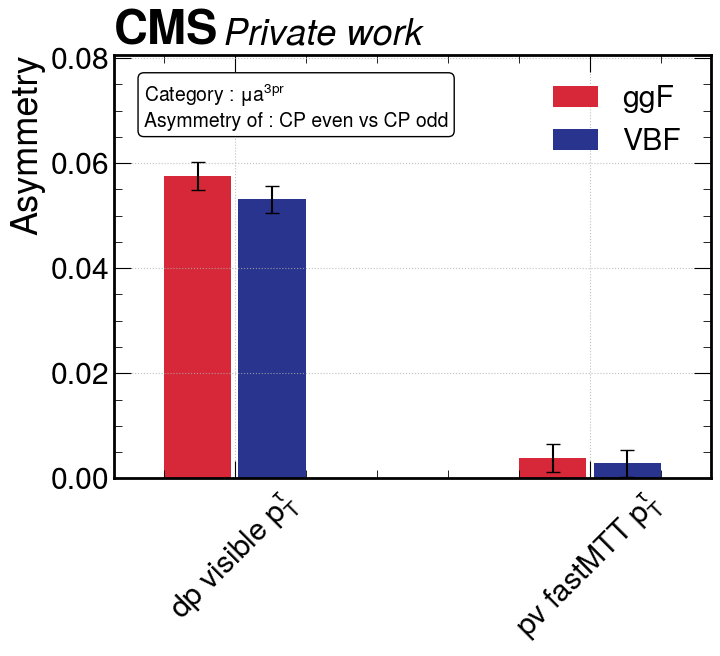

selected_cats ['cat_mutau_sr__jet_fakes__fake']
selected_datasets: ['03_test_small/ggF', '03_test_small/VBF']
selected_tags ['dp Reco', 'pv MTT']
selected_keys ['cp_even_vs_cp_odd']
math_label = cat_mutau_sr__jet_fakes__fake
dir_name :  03_test_small/ggF
dir_name :  03_test_small/VBF
dir_name :  03_test_small/ggF
ggF erkannt: 03_test_small/ggF, label: dp Reco, value: 0.05759571242953011
dir_name :  03_test_small/ggF
ggF erkannt: 03_test_small/ggF, label: pv MTT, value: 0.003847929062523964
dir_name :  03_test_small/VBF
VBF erkannt: 03_test_small/VBF, label: dp Reco, value: 0.053083664213987726
dir_name :  03_test_small/VBF
VBF erkannt: 03_test_small/VBF, label: pv MTT, value: 0.0028282752470983005
filtered_labels:  ['dp Reco', 'pv MTT']


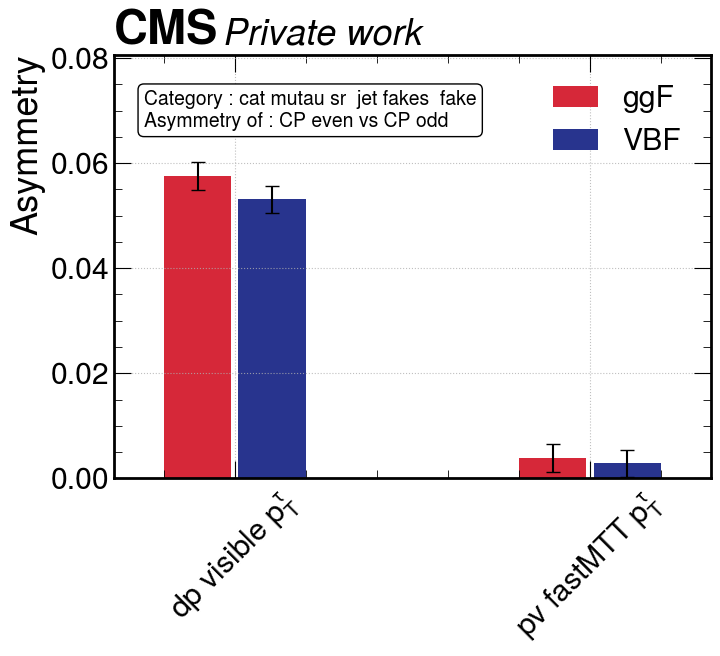

In [9]:
for chosen_category in chosen_categories:
    compare_asymmetries_pv(
    data_storage,
    selected_cats=[simpledict[chosen_category]['simple']],
    selected_datasets=['05_DesyTau_fix_MTT/ggF', '05_DesyTau_fix_MTT/VBF'],
    selected_tags=['dp Reco', 'pv Reco','pv MTT', 'pv GEF'],
    selected_keys=['cp_even_vs_cp_odd']
    )

In [ ]:
# Before saving: convert defaultdict to dict
data_storage_dict = {k: dict(v) for k, v in data_storage.items()}

# Save data_storage to YAML
with open('data_storage_DesyTau.pkl', 'wb') as file:
    pickle.dump(data_storage_dict, file) 
